In [2]:
%%time

import tensorflow as tf
print(tf.__version__)
import sys
sys.path.append("..")
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from catenets.models.jax import TNet, SNet, OFFSET_NAME, FlexTENet, OffsetNet, SNet1, SNet2
from catenets.experiment_utils.simulation_utils import simulate_treatment_setup

#catenets (SNet, FlexTENet, OffsetNet, TNet, SNet1 (TARNet), SNet2 (DragonNet)
def plot_loss(history, *losses):
    for loss in losses:
        plt.plot(history.history[loss], label=loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def scaling(x, min, max):
    return np.where(x < min, 0.0, np.where(x > max, 1.0, (x - min) / (max - min)))

early_stopping = EarlyStopping(
    monitor='val_loss',  # 
    patience=500,        # 
    verbose=1,          # 
    mode='min',         # 
    restore_best_weights=True  # 
)

2024-02-23 12:23:30.569446: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-23 12:23:30.675344: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 12:23:30.675410: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 12:23:30.675463: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-23 12:23:30.693819: I tensorflow/core/platform/cpu_feature_g

2.14.0
CPU times: user 10.7 s, sys: 4.1 s, total: 14.8 s
Wall time: 12.1 s


In [3]:
SAVE_DIR = "../data"
file_criteo = SAVE_DIR + "/MT-LIFT/train.csv"
df_criteo_ori = pd.read_csv(file_criteo, sep=',')

In [3]:
%%time

sample = 1.0
random_state=20220720
df_criteo=df_criteo_ori[(df_criteo_ori['treatment'] == 0) | (df_criteo_ori['treatment'] == 3)].sample(frac=sample, random_state=random_state).reset_index(drop=True)
# Change 'treatment' from 3 to 1 in df_criteo_ori
df_criteo['treatment'] = df_criteo['treatment'].replace(3, 1)

# X = df_criteo[['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']].values

# X[:, 0] = scaling(X[:, 0], min=np.min(X[:, 0]), max=np.max(X[:, 0]))
# X[:, 1] = scaling(X[:, 1], min=np.min(X[:, 1]), max=np.max(X[:, 1]))
# X[:, 2] = scaling(X[:, 2], min=np.min(X[:, 2]), max=np.max(X[:, 2]))
# X[:, 3] = scaling(X[:, 3], min=np.min(X[:, 3]), max=np.max(X[:, 3]))
# X[:, 4] = scaling(X[:, 4], min=np.min(X[:, 4]), max=np.max(X[:, 4]))
# X[:, 5] = scaling(X[:, 5], min=np.min(X[:, 5]), max=np.max(X[:, 5]))
# X[:, 6] = scaling(X[:, 6], min=np.min(X[:, 6]), max=np.max(X[:, 6]))
# X[:, 7] = scaling(X[:, 7], min=np.min(X[:, 7]), max=np.max(X[:, 7]))
# X[:, 8] = scaling(X[:, 8], min=np.min(X[:, 8]), max=np.max(X[:, 8]))
# X[:, 9] = scaling(X[:, 9], min=np.min(X[:, 9]), max=np.max(X[:, 9]))
# X[:, 10] = scaling(X[:, 10], min=np.min(X[:, 10]), max=np.max(X[:, 10]))
# X[:, 11] = scaling(X[:, 11], min=np.min(X[:, 11]), max=np.max(X[:, 11]))
# # 
columns = [f'f{i}' for i in range(99) if not (80 <= i <= 82)] 
X = df_criteo[columns].values
# 
for i in range(X.shape[1]):
    # 
    if i not in [80, 81, 82]:
        X[:, i] = scaling(X[:, i], min=np.min(X[:, i]), max=np.max(X[:, i]))

T = df_criteo['treatment'].values.reshape(-1, 1)
Y_visit = df_criteo['click'].values.reshape(-1, 1)
Y_conv = df_criteo['conversion'].values.reshape(-1, 1)


T.shape, Y_visit.shape, Y_conv.shape


# calculate len
train_len = int(len(X) * 0.70)
cali_len = int(len(X) * 0.05)
test_len = len(X) - train_len - cali_len

# obtain train set
X_train = X[:train_len, :]
T_train = T[:train_len, :]
Y_visit_train = Y_visit[:train_len, :]
Y_conv_train = Y_conv[:train_len, :]

# obtain calibration set
X_cali = X[train_len:train_len+cali_len, :]
T_cali = T[train_len:train_len+cali_len, :]
Y_visit_cali = Y_visit[train_len:train_len+cali_len, :]
Y_conv_cali = Y_conv[train_len:train_len+cali_len, :]

# obtain test set
X_test = X[train_len+cali_len:, :]
T_test = T[train_len+cali_len:, :]
Y_visit_test = Y_visit[train_len+cali_len:, :]
Y_conv_test = Y_conv[train_len+cali_len:, :]

print(train_len, X_train.shape, X_test.shape, len(X), X_cali.shape)

# make covariate shift
# condition_cali = (X_cali[:, 0] > 0.3) & (X_cali[:, 1] < 0.7)
# X_cali = X_cali[condition_cali]
# T_cali = T_cali[condition_cali]
# Y_visit_cali = Y_visit_cali[condition_cali]
# Y_conv_cali = Y_conv_cali[condition_cali]

# condition_test = (X_test[:, 0] > 0.3) & (X_test[:, 1] < 0.7)
# X_test = X_test[condition_test]
# T_test = T_test[condition_test]
# Y_visit_test = Y_visit_test[condition_test]
# Y_conv_test = Y_conv_test[condition_test]

# print(train_len, X_train.shape, X_test.shape, len(X), X_cali.shape)

2041521 (2041521, 96) (729116, 96) 2916459 (145822, 96)
CPU times: user 8.88 s, sys: 5.36 s, total: 14.2 s
Wall time: 14.2 s


### SNET

In [15]:
# visit
s = SNet(penalty_orthogonal=0.01,batch_size=10000)
s.fit(X_train, Y_visit_train.reshape(-1), T_train.reshape(-1))
cate_pred_s_visit = s.predict(X_test)

In [17]:
# conv
s = SNet(penalty_orthogonal=0.01,batch_size=10000)
s.fit(X_train, Y_conv_train.reshape(-1), T_train.reshape(-1))
cate_pred_s_conv = s.predict(X_test)

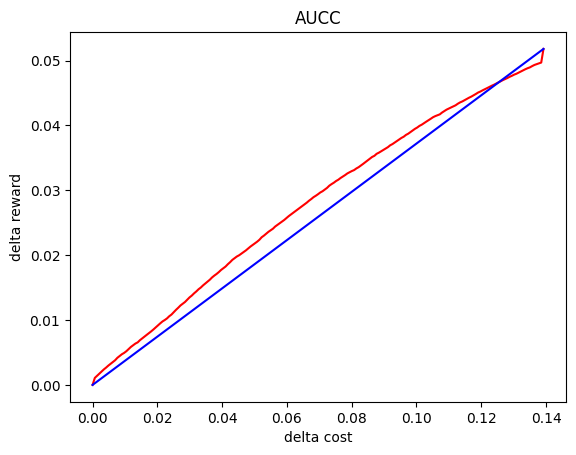

,delta_cost,delta_reward,n_treatment,n_control,roi_pred_treatment,roi_pred_control
0,0.000000,0.000000,0,0,0,0
1,0.000696,0.001083,4397,4028,21.006235,20.830292
2,0.001393,0.001408,5663,4911,16.726196,17.419415
3,0.002089,0.001750,6741,5612,14.307478,15.443343
4,0.002785,0.002068,7774,6273,12.596861,13.967079
...,...,...,...,...,...,...
196,0.136425,0.049337,307135,198095,0.7925367,0.89712214
197,0.137120,0.049455,310357,200844,0.7870949,0.88851607
198,0.137815,0.049564,313521,203486,0.7818038,0.8803932
199,0.138511,0.049705,316124,205669,0.7774885,0.8737843


AUCC =  0.539207674663446


In [18]:
import sklearn 
import sklearn.metrics
from metric.Metric import *

direct_ratio_SL_aucc_list = []
roi_slearner_pre = cate_pred_s_conv / np.where(abs(cate_pred_s_visit) < 1e-6, 1e-6, cate_pred_s_visit)

direct_ratio_SL_aucc = get_uplift_model_aucc(t=(T_test > 0.5).flatten(), y_reward=Y_conv_test.flatten(), y_cost=Y_visit_test.flatten(), roi_pred=roi_slearner_pre.flatten(), quantile=200)
direct_ratio_SL_aucc_list.append(direct_ratio_SL_aucc)

In [19]:
# store test aucc for pic 
import pandas as pd

def get_aucc_cost_curve(aucc_list):
    delta_cost_list_group = np.array([aucc[1] for aucc in aucc_list])
    delta_reward_list_group = np.array([aucc[2] for aucc in aucc_list])
    
    avg_delta_cost_list = np.mean(delta_cost_list_group, axis=0)
    avg_delta_reward_list = np.mean(delta_reward_list_group, axis=0)
    
    df_aucc_cost_curve = pd.DataFrame(avg_delta_cost_list, columns=['delta_cost'])
    df_aucc_cost_curve['delta_reward'] = avg_delta_reward_list
    
    return df_aucc_cost_curve

A_direct_ratio_SL_aucc_list = get_aucc_cost_curve(direct_ratio_SL_aucc_list)
print("aucc = ", np.sum(A_direct_ratio_SL_aucc_list['delta_reward'].values) / (A_direct_ratio_SL_aucc_list['delta_reward'].values[-1] * 201))
A_direct_ratio_SL_aucc_list.to_csv("../figure/mt/A_snet_aucc_list.csv")

aucc =  0.539207674663446


### OffsetNet

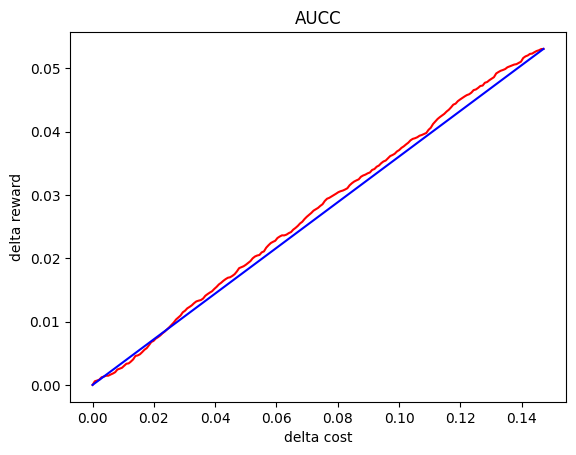

,delta_cost,delta_reward,n_treatment,n_control,roi_pred_treatment,roi_pred_control
0,0.000000,0.000000,0,0,0,0
1,0.000744,0.000581,331,241,0.50618213,0.72599816
2,0.001492,0.000695,397,268,0.5039211,0.7024749
3,0.002214,0.000836,520,336,0.500915,0.65971315
4,0.002945,0.001210,638,405,0.4988345,0.63076687
...,...,...,...,...,...,...
196,0.144187,0.052547,38404,29331,0.38197532,0.379719
197,0.144900,0.052730,38720,29612,0.38060006,0.3781472
198,0.145650,0.052847,39410,30209,0.37736467,0.37454784
199,0.146371,0.053032,40587,31253,0.37029484,0.366451


AUCC =  0.5164176616284942
aucc =  0.5164176616284942
CPU times: user 2h 19min 46s, sys: 16min 40s, total: 2h 36min 26s
Wall time: 19min 49s


In [37]:
%%time
# visit
s = OffsetNet(batch_size=10000,n_iter=300)
s.fit(X_train, Y_visit_train.reshape(-1), T_train.reshape(-1))
cate_pred_s_visit = s.predict(X_test)

# conv
s = OffsetNet(batch_size=10000,n_iter=300)
s.fit(X_train, Y_conv_train.reshape(-1), T_train.reshape(-1))
cate_pred_s_conv = s.predict(X_test)


import sklearn 
import sklearn.metrics
from metric.Metric import *

direct_ratio_SL_aucc_list = []
roi_slearner_pre = cate_pred_s_conv / np.where(abs(cate_pred_s_visit) < 1e-6, 1e-6, cate_pred_s_visit)

direct_ratio_SL_aucc = get_uplift_model_aucc(t=(T_test > 0.5).flatten(), y_reward=Y_conv_test.flatten(), y_cost=Y_visit_test.flatten(), roi_pred=roi_slearner_pre.flatten(), quantile=200)
direct_ratio_SL_aucc_list.append(direct_ratio_SL_aucc)

# store test aucc for pic 
import pandas as pd

def get_aucc_cost_curve(aucc_list):
    delta_cost_list_group = np.array([aucc[1] for aucc in aucc_list])
    delta_reward_list_group = np.array([aucc[2] for aucc in aucc_list])
    
    avg_delta_cost_list = np.mean(delta_cost_list_group, axis=0)
    avg_delta_reward_list = np.mean(delta_reward_list_group, axis=0)
    
    df_aucc_cost_curve = pd.DataFrame(avg_delta_cost_list, columns=['delta_cost'])
    df_aucc_cost_curve['delta_reward'] = avg_delta_reward_list
    
    return df_aucc_cost_curve

A_direct_ratio_SL_aucc_list = get_aucc_cost_curve(direct_ratio_SL_aucc_list)
print("aucc = ", np.sum(A_direct_ratio_SL_aucc_list['delta_reward'].values) / (A_direct_ratio_SL_aucc_list['delta_reward'].values[-1] * 201))
A_direct_ratio_SL_aucc_list.to_csv("../figure/mt/a_OffsetNet_aucc_list.csv")

### SNet1 (TARNet)

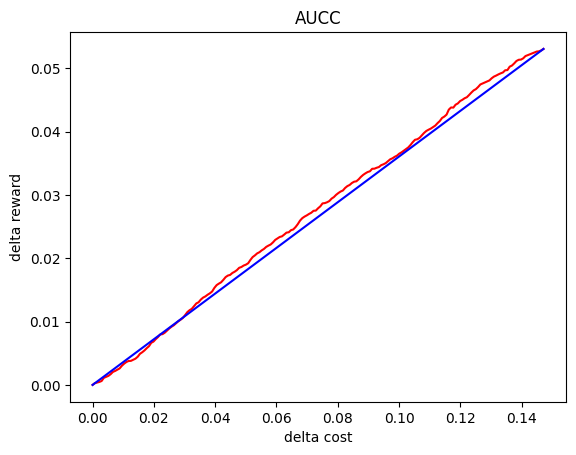

,delta_cost,delta_reward,n_treatment,n_control,roi_pred_treatment,roi_pred_control
0,0.000000,0.000000,0,0,0,0
1,0.000740,0.000277,312,262,0.4846131,0.48550934
2,0.001490,0.000377,379,291,0.48141482,0.48361605
3,0.002207,0.000469,519,378,0.47657913,0.47900507
4,0.002947,0.000620,806,604,0.46923846,0.47038558
...,...,...,...,...,...,...
196,0.144173,0.052467,37944,28843,0.28979725,0.2874116
197,0.144917,0.052640,38155,29026,0.28870785,0.28618512
198,0.145648,0.052676,38532,29338,0.2867013,0.284029
199,0.146382,0.052825,38759,29548,0.28545153,0.28253204


AUCC =  0.5147318046628261
aucc =  0.5147318046628261
CPU times: user 1h 42min 36s, sys: 11min 47s, total: 1h 54min 23s
Wall time: 18min 8s


In [39]:
%%time
# visit
s = SNet1(batch_size=10000,n_iter=300)
s.fit(X_train, Y_visit_train.reshape(-1), T_train.reshape(-1))
cate_pred_s_visit = s.predict(X_test)

# conv
s = SNet1(batch_size=10000,n_iter=300)
s.fit(X_train, Y_conv_train.reshape(-1), T_train.reshape(-1))
cate_pred_s_conv = s.predict(X_test)


import sklearn 
import sklearn.metrics
from metric.Metric import *

direct_ratio_SL_aucc_list = []
roi_slearner_pre = cate_pred_s_conv / np.where(abs(cate_pred_s_visit) < 1e-6, 1e-6, cate_pred_s_visit)

direct_ratio_SL_aucc = get_uplift_model_aucc(t=(T_test > 0.5).flatten(), y_reward=Y_conv_test.flatten(), y_cost=Y_visit_test.flatten(), roi_pred=roi_slearner_pre.flatten(), quantile=200)
direct_ratio_SL_aucc_list.append(direct_ratio_SL_aucc)

# store test aucc for pic 
import pandas as pd

def get_aucc_cost_curve(aucc_list):
    delta_cost_list_group = np.array([aucc[1] for aucc in aucc_list])
    delta_reward_list_group = np.array([aucc[2] for aucc in aucc_list])
    
    avg_delta_cost_list = np.mean(delta_cost_list_group, axis=0)
    avg_delta_reward_list = np.mean(delta_reward_list_group, axis=0)
    
    df_aucc_cost_curve = pd.DataFrame(avg_delta_cost_list, columns=['delta_cost'])
    df_aucc_cost_curve['delta_reward'] = avg_delta_reward_list
    
    return df_aucc_cost_curve

A_direct_ratio_SL_aucc_list = get_aucc_cost_curve(direct_ratio_SL_aucc_list)
print("aucc = ", np.sum(A_direct_ratio_SL_aucc_list['delta_reward'].values) / (A_direct_ratio_SL_aucc_list['delta_reward'].values[-1] * 201))
A_direct_ratio_SL_aucc_list.to_csv("../figure/mt/a_SNet1_aucc_list.csv")

### SNet2 (DragonNet)

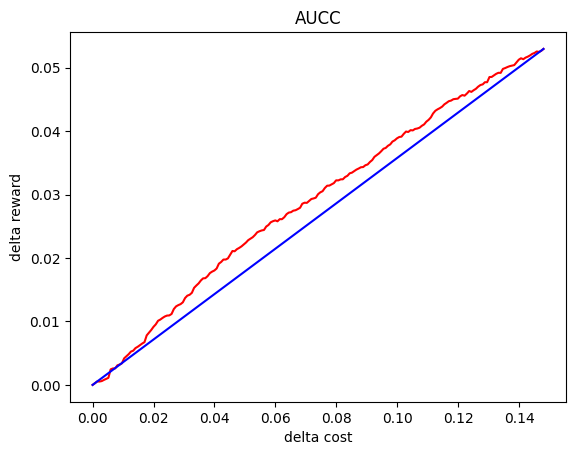

,delta_cost,delta_reward,n_treatment,n_control,roi_pred_treatment,roi_pred_control
0,0.000000,0.000000,0,0,0,0
1,0.000770,0.000263,351,287,2.4904945,1.6436093
2,0.001482,0.000546,500,425,1.9447066,1.3248891
3,0.002222,0.000532,553,459,1.8176328,1.2726823
4,0.003002,0.000606,716,587,1.5383995,1.1238258
...,...,...,...,...,...,...
196,0.145021,0.052335,19311,14718,0.40762538,0.39439172
197,0.145747,0.052563,19390,14780,0.40650386,0.39329052
198,0.146515,0.052506,19691,15023,0.4018878,0.38860855
199,0.147235,0.052672,19818,15145,0.3997026,0.38598004


AUCC =  0.5478576480785656
aucc =  0.5478576480785656
CPU times: user 8h 3min 47s, sys: 37min 51s, total: 8h 41min 38s
Wall time: 47min 20s


In [5]:
%%time
# visit
s = SNet2(batch_size=10000)
s.fit(X_train, Y_visit_train.reshape(-1), T_train.reshape(-1))
cate_pred_s_visit = s.predict(X_test)

# conv
s = SNet2(batch_size=10000)
s.fit(X_train, Y_conv_train.reshape(-1), T_train.reshape(-1))
cate_pred_s_conv = s.predict(X_test)


import sklearn 
import sklearn.metrics
from metric.Metric import *

direct_ratio_SL_aucc_list = []
roi_slearner_pre = cate_pred_s_conv / np.where(abs(cate_pred_s_visit) < 1e-6, 1e-6, cate_pred_s_visit)

direct_ratio_SL_aucc = get_uplift_model_aucc(t=(T_test > 0.5).flatten(), y_reward=Y_conv_test.flatten(), y_cost=Y_visit_test.flatten(), roi_pred=roi_slearner_pre.flatten(), quantile=200)
direct_ratio_SL_aucc_list.append(direct_ratio_SL_aucc)

# store test aucc for pic 
import pandas as pd

def get_aucc_cost_curve(aucc_list):
    delta_cost_list_group = np.array([aucc[1] for aucc in aucc_list])
    delta_reward_list_group = np.array([aucc[2] for aucc in aucc_list])
    
    avg_delta_cost_list = np.mean(delta_cost_list_group, axis=0)
    avg_delta_reward_list = np.mean(delta_reward_list_group, axis=0)
    
    df_aucc_cost_curve = pd.DataFrame(avg_delta_cost_list, columns=['delta_cost'])
    df_aucc_cost_curve['delta_reward'] = avg_delta_reward_list
    
    return df_aucc_cost_curve

A_direct_ratio_SL_aucc_list = get_aucc_cost_curve(direct_ratio_SL_aucc_list)
print("aucc = ", np.sum(A_direct_ratio_SL_aucc_list['delta_reward'].values) / (A_direct_ratio_SL_aucc_list['delta_reward'].values[-1] * 201))
A_direct_ratio_SL_aucc_list.to_csv("../figure/mt/a_SNet2_aucc_list.csv")